# Chest X-RAY Tuberculosis Analysis using Deep Learning

**Description:** The standard digital image database for Tuberculosis is created by the National Library of Medicine, Maryland, USA in collaboration with Shenzhen No.3 People’s Hospital, Guangdong Medical College, Shenzhen, China. The Chest X-rays are from out-patient clinics, and were captured as part of the daily routine using Philips DR Digital Diagnose systems. 
Number of X-rays: 
-	336 cases with manifestation of tuberculosis, and 
-	326 normal cases.
Image parameters: 
-	Format: PNG
-	Image size varies for each X-ray. It is approximately 3K x 3K.


**Problem Statement:** Using Deep Learning detect Tuberculosis of a patient by analysing his X-Ray report.

### Deep Learning problem

1. Using VGG-19, ResNet50 and Inception-V3 networks build models. 
2. Use accuracy to compare performance of the three models. 
3. Write a function to tune the threshold of the best model such that the AUC of the model is above x%(let default be 90%) and plot the confusion matrix with that tuned threshold.

In [1]:
# initiating tensorflow and check GPU connection
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")

Using TensorFlow backend.


In [0]:
# Download the dataset to colab directory
%%capture
!wget  http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip


In [4]:
# Unzip the zipped folder and store data in Train folder
!unzip ChinaSet_AllFiles.zip
!mv ChinaSet_AllFiles train
!find train/CXR_png -size  0 -print0 |xargs -0 rm --

Archive:  ChinaSet_AllFiles.zip
   creating: ChinaSet_AllFiles/ClinicalReadings/
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0001_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0002_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0003_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0004_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0005_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0006_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0007_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0008_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0009_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0010_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0011_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0012_0.txt  
 extracting: ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0013_0.txt  
 extracting: ChinaSet_AllFiles/Clin

In [0]:
# creating two seperate data, one for patients with TB other with Non TB.
from glob import glob
ntb = glob('train/CXR_png/*_0.png')
tb = glob('train/CXR_png/*_1.png')

In [0]:
# create a directory called train_main and store data with TB and NonTB seperately in two folders.
!mkdir train_main
!mkdir train_main/ntb
files = ' '.join(ntb)
!mv -t train_main/ntb $files

In [0]:
!mkdir train_main/tb
files = ' '.join(tb)
!mv -t train_main/tb $files

In [0]:
ntb_1 = glob('train_main/ntb/*.png')
tb_1 = glob('train_main/tb/*.png')

In [0]:
# splitting data into train and test with 10% test data 
from sklearn.model_selection import train_test_split
ntb_train, ntb_test = train_test_split(ntb_1, test_size=0.10)
tb_train, tb_test = train_test_split(tb_1, test_size=0.10)

In [0]:
# create new directories for test data
!mkdir test
!mkdir test/ntb
files = ' '.join(ntb_test)
!mv -t test/ntb $files

!mkdir test/tb
files = ' '.join(tb_test)
!mv -t test/tb $files

In [0]:
# defining test and train models in constants
TRAIN_DIR = 'train_main'
TEST_DIR = 'test'

### Inception V3:

In [12]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


** Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize.**

### Data augmentation:

In [13]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 595 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [14]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
320/320 [==============================] - 1103s 3s/step - loss: 0.6060 - acc: 0.6803 - val_loss: 1.1975 - val_acc: 0.4934
Epoch 2/5
320/320 [==============================] - 1053s 3s/step - loss: 0.5279 - acc: 0.7506 - val_loss: 1.0031 - val_acc: 0.5087
Epoch 3/5
320/320 [==============================] - 1052s 3s/step - loss: 0.5140 - acc: 0.7639 - val_loss: 1.1354 - val_acc: 0.5078
Epoch 4/5
320/320 [==============================] - 1048s 3s/step - loss: 0.5050 - acc: 0.7657 - val_loss: 0.8262 - val_acc: 0.5483
Epoch 5/5
320/320 [==============================] - 1044s 3s/step - loss: 0.5001 - acc: 0.7724 - val_loss: 0.7300 - val_acc: 0.5921


In [16]:
# testing the model
model.evaluate_generator(validation_generator, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

[0.7830418944358826, 0.5625]

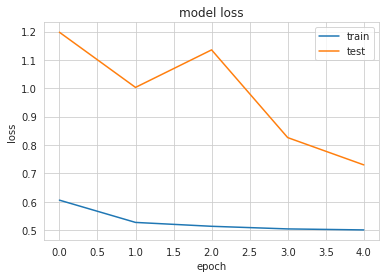

In [17]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## RESNET 50

In [18]:
from keras.applications.resnet50 import ResNet50, preprocess_input
HEIGHT = 300
WIDTH = 300
CLASSES = 2
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 595 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [21]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'resnet.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 1092s 3s/step - loss: 0.5409 - acc: 0.7496 - val_loss: 0.9962 - val_acc: 0.5254
Epoch 2/5
320/320 [==============================] - 1043s 3s/step - loss: 0.4713 - acc: 0.7956 - val_loss: 0.8136 - val_acc: 0.5608
Epoch 3/5
320/320 [==============================] - 1047s 3s/step - loss: 0.4491 - acc: 0.8071 - val_loss: 0.9624 - val_acc: 0.5298
Epoch 4/5
320/320 [==============================] - 1047s 3s/step - loss: 0.4382 - acc: 0.8096 - val_loss: 1.2458 - val_acc: 0.4997
Epoch 5/5
320/320 [==============================] - 1055s 3s/step - loss: 0.4383 - acc: 0.8117 - val_loss: 1.7746 - val_acc: 0.4976


In [22]:
# testing the model
model.evaluate_generator(validation_generator, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

[2.0481433868408203, 0.4375]

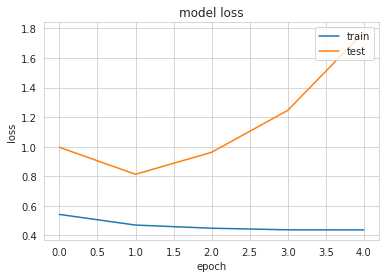

In [23]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## VGG 19

In [24]:
from keras.applications import VGG19
HEIGHT = 224
WIDTH = 224
CLASSES = 2
BATCH_SIZE = 32
 
base_model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(HEIGHT, WIDTH, 3))

80142336/80134624 [==============================] - 2s 0us/step


In [0]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg19 import vgg19, preprocess_input

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
from keras.preprocessing.image import ImageDataGenerator


# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 595 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [27]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'vgg19.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 1029s 3s/step - loss: 1.0649 - acc: 0.6947 - val_loss: 0.4783 - val_acc: 0.8047
Epoch 2/5
320/320 [==============================] - 991s 3s/step - loss: 0.5543 - acc: 0.7749 - val_loss: 0.5389 - val_acc: 0.7755
Epoch 3/5
320/320 [==============================] - 982s 3s/step - loss: 0.5115 - acc: 0.7794 - val_loss: 0.5436 - val_acc: 0.7362
Epoch 4/5
320/320 [==============================] - 997s 3s/step - loss: 0.4873 - acc: 0.7882 - val_loss: 0.4947 - val_acc: 0.7985
Epoch 5/5
320/320 [==============================] - 996s 3s/step - loss: 0.4903 - acc: 0.7864 - val_loss: 0.4267 - val_acc: 0.8277


In [28]:
# testing the model
model.evaluate_generator(validation_generator, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

[0.4274943470954895, 0.78125]

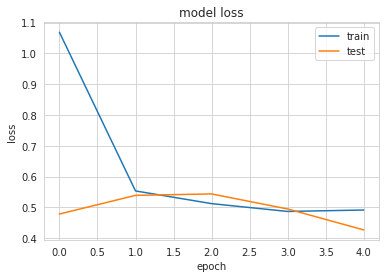

In [29]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Summary:

In [30]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Test loss", "Test Accuracy"]

x.add_row(["Inception V3", "0.56", "0.78"])
x.add_row(["Resnet 50", "2.04", "0.43"])
x.add_row(["VGG 19", "0.42", '0.78'])


print(x)

+--------------+-----------+---------------+
|    Model     | Test loss | Test Accuracy |
+--------------+-----------+---------------+
| Inception V3 |    0.56   |      0.78     |
|  Resnet 50   |    2.04   |      0.43     |
|    VGG 19    |    0.42   |      0.78     |
+--------------+-----------+---------------+


By observing from the above data, we can clearly conclude that VGG19 works best with highest test accuracy and lowest test loss. So we would proceed predictions with VGG19 model.

#### Predictions:

In [0]:
# defining functions to visualise and test the data 


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]
  
def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("tb", "ntb")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [0]:
# importing packages
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
model = load_model(MODEL_FILE)

array([0.9937085 , 0.00629148], dtype=float32)

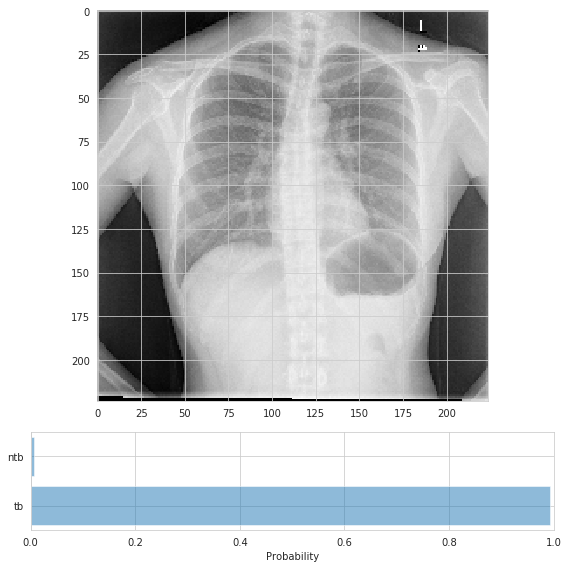

In [0]:
# visualizing a test case
img = image.load_img('test/tb/CHNCXR_0328_1.png', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [0]:
# predicting the output of the images
y_pred = []

directory = 'test/tb/'
import os

for filename in os.listdir(directory):
    if filename.endswith(".png"): 
        img = image.load_img(directory + filename, target_size=(HEIGHT, WIDTH))
        preds = predict(model, img)
        y_pred.append(preds[0])
        continue
    else:
        continue

In [0]:
# appending class levels to a list
path="test/"
tb_test = path + "tb/"

label_tb_t = []

for i in range(34):
    label_tb_t.append("1")

In [0]:
# typecasting
labels = np.asarray(label_tb_t)
labels = labels.astype(int)

In [0]:
y_pred_1 = np.asarray(y_pred).reshape(-1, 1)
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.7 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_1, 0.7)

In [0]:
# 
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels, y_pred_class)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [0]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [0]:
evaluate_threshold(0.8)

Sensitivity: 0.7352941176470589
Specificity: nan


In [0]:
print(metrics.confusion_matrix(labels, y_pred_class))

[[ 0  0]
 [ 9 25]]


## OBSERVATION: 

1. Among all the models used VGG19 gave the a test accuracy of 78%. We got an validation accuracy of nearly 80% in that case. 
2. VGG19 model also had lowest test loss of 0.42.
3. By taking a treshold of 0.8 we got a sensitivity of 0.73.
4. We have seen that our model work really good as confusion matrix had higher true positives. 
5. We have got specificity as nan because the class levels we considered are only 1, so in that case our *'fpr*' rate turned out to be *nan* after calculation. 
6. We also visualised that our prediction for the x-ray image was remarkable with test accuracy of >90%
